In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Aprendizaje de variedades

Una de las debilidades del PCA es que no puede detectar características no lineales. Un conjunto de algoritmos que evitan este problema son los algoritmos de aprendizaje de variedades (*manifold learning*). Un conjunto de datos que se suele emplear a menudo en este contexto es el *S-curve*:

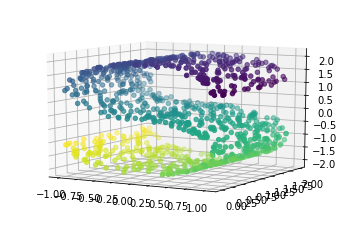

In [2]:
from sklearn.datasets import make_s_curve
X, y = make_s_curve(n_samples=1000)

from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.view_init(10, -60);

Este es en realidad un conjunto de datos 2D (que sería la S desenrollada), pero se ha embebido en un espacio 3D, de tal forma que un PCA no es capaz de descubrir el conjunto de datos original

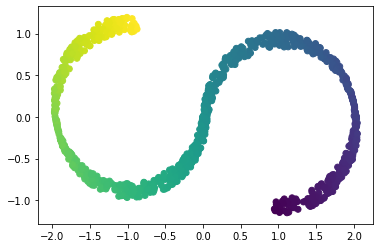

In [12]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y);

Como puedes observar, al ser un método lineal, el PCA ha obtenido dos direcciones máxima variabilidad, pero ha perdido muchísima varianza en los datos, al proyectar la S directamente en un hiperplano. Los algoritmos de aprendizaje de variedades, disponibles en el paquete ``sklearn.manifold``, pretenden descubrir el *manifold* que contiene a los datos (en este caso, es un *manifold* de dos dimensiones). Apliquemos, por ejemplo, el método Isomap:

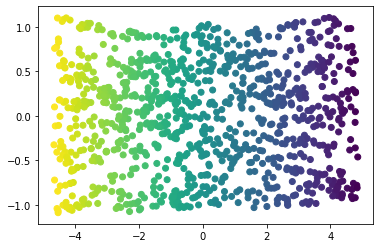

In [4]:
from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=15, n_components=2)
X_iso = iso.fit_transform(X)
plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y);

## Aprendizaje de variedades para la base de datos de dígitos

Podemos aplicar este tipo de algoritmos para bases de datos de alta dimensionalidad, como la base de datos de dígitos manuscritos:

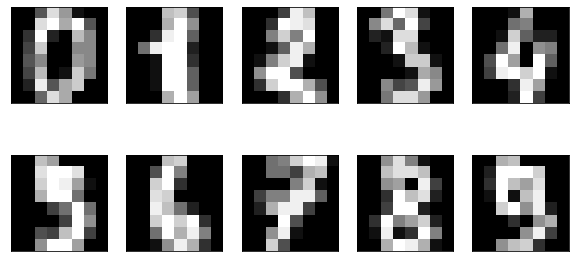

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                         subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img, interpolation="none", cmap="gray")

Si visualizamos el dataset utilizando una técnica lineal como PCA, ya pudimos comprobar como conseguíamos algo de información sobre la estructura de los datos:

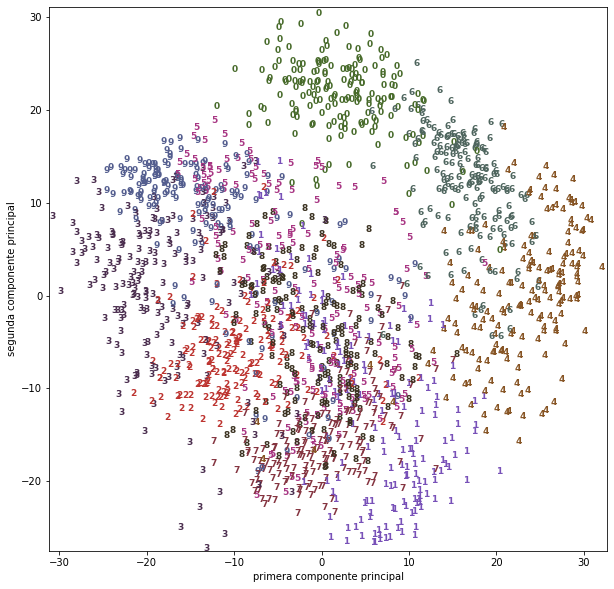

In [6]:
# Construir un modelo PCA
pca = PCA(n_components=2)
pca.fit(digits.data)
# Transformar los dígitos según las dos primeras componentes principales
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120","#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max() + 1)
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max() + 1)
for i in range(len(digits.data)):
    # Representar los dígitos usando texto
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("primera componente principal")
plt.ylabel("segunda componente principal");

Sin embargo, podemos usar técnicas no lineales, que nos llevarán, en este caso, a una mejor visualización. Vamos a aplicar el método t-SNE de *manifold learning*:

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# utilizamos fit_transform en lugar de fit:
digits_tsne = tsne.fit_transform(digits.data)

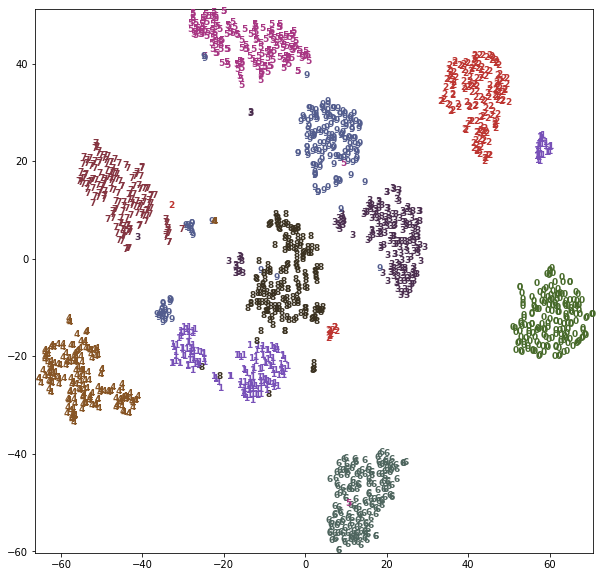

In [8]:
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})

t-SNE suele tardar más en ejecutarse que otros algoritmos de aprendizaje de variedades, pero el resultado suele ser muy bueno. Ten en cuenta que este algoritmo es no supervisado y no sabe nada sobre las etiquetas de los dígitos. Aún así, es capaz de separar muy bien las clases (aunque los dígitos 4, 1 y 9 se han subdividido en varios grupos).

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
      Compara los resultados que se obtienen al aplicar Isomap, PCA y t-SNE a los dígitos manuscritos. ¿Qué algoritmo crees que lo hace mejor?
      </li>
      <li>
      Dado que t-SNE separa muy bien las clases, uno puede pensar en aplicarlo como preprocesamiento antes de un algoritmo de clasificación. Entrena un Knn en el dataset de los dígitos preprocesado con t-SNE y compara la precisión cuando lo hacemos sin preprocesamiento. Sin embargo, ten en cuenta que t-SNE no tiene método tranform y por tanto no se podría utilizar en producción.
      </li>
    </ul>
</div>

In [16]:
iso = Isomap(n_neighbors=15, n_components=2)
digits_iso = iso.fit_transform(digits.data)

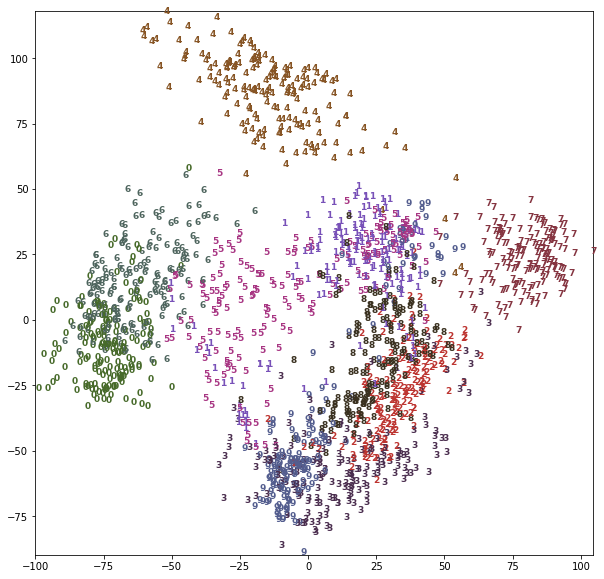

In [15]:
plt.figure(figsize=(10, 10))
plt.xlim(digits_iso[:, 0].min(), digits_iso[:, 0].max() + 1)
plt.ylim(digits_iso[:, 1].min(), digits_iso[:, 1].max() + 1)
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_iso[i, 0], digits_iso[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

knn = KNeighborsClassifier()

X_digits = digits.data
y_digits = digits.target

#con preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(tsne.fit_transform(X_digits), y_digits, random_state=42)
#sin preprocesamiento
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_digits, y_digits, random_state=42)

knn.fit(X_train, y_train)
print("Score con preprocesamiento:", knn.score(X_test, y_test))

knn.fit(X_train2, y_train2)
print("Score sin preprocesamiento:", knn.score(X_test2, y_test2))

Score con preprocesamiento: 0.9866666666666667
Score sin preprocesamiento: 0.9933333333333333
